In [115]:
olympics = pd.read_csv("~/Documents/datasets/olympics/athlete_events.csv")
attributes = ["Sex","Age","Height","Weight","Team","Games","Sport","City","Year","Season","Medal"]
olympics_sum = olympics[attributes]
#olympics_sum.loc[:,"bmi"] = olympics["Weight"] / (olympics["Height"] / 100) ** 2
olympics_sum = olympics_sum.dropna(subset=["Medal"])
olympics.describe()
age_mean = olympics_sum["Age"].mean()
height_mean = olympics_sum["Height"].mean()
weight_mean = olympics_sum["Weight"].mean()
age_median = olympics_sum["Age"].median()
height_median = olympics_sum["Height"].median()
weight_median = olympics_sum["Weight"].median()
olympics_sum.Age = olympics_sum["Age"].fillna(age_mean)
olympics_sum.Height = olympics_sum["Height"].fillna(height_mean)
olympics_sum.Weight = olympics_sum["Weight"].fillna(weight_mean)
olympics_sum.head()

,Sex,Age,Height,Weight,Team,Games,Sport,City,Year,Season,Medal
3,M,34.0,177.554197,73.77068,Denmark/Sweden,1900 Summer,Tug-Of-War,Paris,1900,Summer,Gold
37,M,30.0,177.554197,73.77068,Finland,1920 Summer,Swimming,Antwerpen,1920,Summer,Bronze
38,M,30.0,177.554197,73.77068,Finland,1920 Summer,Swimming,Antwerpen,1920,Summer,Bronze
40,M,28.0,184.000000,85.00000,Finland,2014 Winter,Ice Hockey,Sochi,2014,Winter,Bronze
41,M,28.0,175.000000,64.00000,Finland,1948 Summer,Gymnastics,London,1948,Summer,Bronze


In [101]:
from sklearn.model_selection import train_test_split

# Handling categorical attributes
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
df = olympics_sum.apply(encoder.fit_transform)
#data["Category"] = encoder.fit_transform(data["Category"].astype('str'))
crimes = df.drop("Medal", axis=1)

crime_cat = df["Medal"]



X_train, X_test, y_train ,y_test = train_test_split(crimes, crime_cat, random_state= 0)


#df.head()
forest = RandomForestClassifier(n_jobs=-1,max_depth=100,n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print('Accuracy on the training subset: {:3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(forest.score(X_test, y_test)))


Accuracy on the training subset: 0.945604
Accuracy on the testing subset: 0.624472


In [175]:
y_train.describe()

count     29837
unique        3
top        Gold
freq      10001
Name: Medal, dtype: object

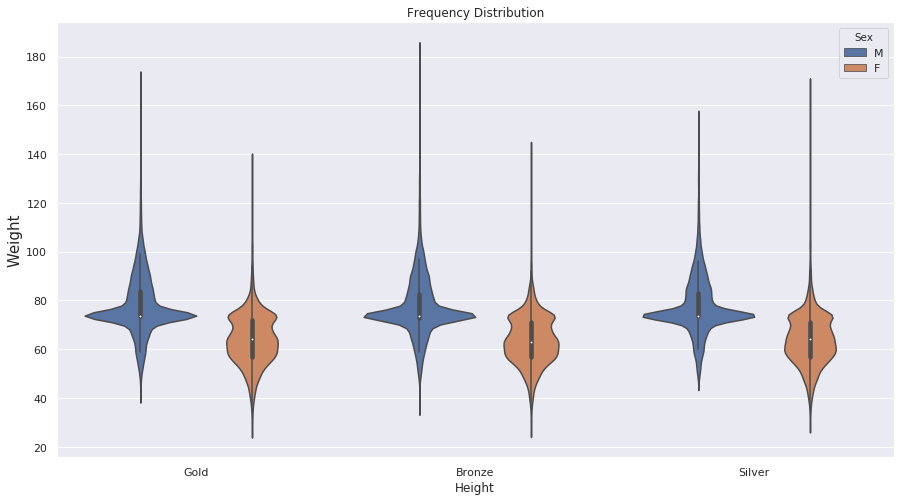

In [128]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

olympics = pd.read_csv("~/Documents/datasets/olympics/athlete_events.csv",nrows=50)
#olympics.describe()


# Set context to "paper"
plt.figure(figsize=(15,8))

sns.set(style="darkgrid")

#sns.scatterplot("Height", "Weight",hue= "Season",data = olympics_sum ,alpha=0.9)
sns.violinplot("Medal","Weight",hue= "Sex",data = olympics_sum )
plt.title('Frequency Distribution')
plt.ylabel('Weight',fontsize=15)
plt.xlabel('Height',fontsize=12)
plt.show()


In [116]:
corr_matrix = olympics_sum.corr()
corr_matrix["Height"].sort_values(ascending=False)

Height    1.000000
Weight    0.788569
Age       0.071064
Year      0.026368
Name: Height, dtype: float64

(Sex       0
 Age       0
 NOC       0
 Games     0
 Year      0
 Season    0
 City      0
 Sport     0
 Event     0
 Medal     0
 BMI       0
 dtype: int64, (100000, 11))

In [22]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

'''
Load some data and do some cleaning
'''
olympics = pd.read_csv("~/Documents/datasets/olympics/athlete_events.csv",nrows = 100000)
attributes = ["Sex","Age","Height","Weight","Team","Games","Sport","City","Year","Season","Medal"]
olympics.Medal = olympics["Medal"].fillna("Copper")
olympics.Age = olympics["Age"].fillna(olympics['Age'].mean())
olympics.Height = olympics["Height"].fillna(olympics['Height'].mean())
olympics.Weight = olympics["Weight"].fillna(olympics['Weight'].mean())

olympics['BMI'] = olympics["Weight"] / (olympics["Height"] ** 2)
olympics.drop(['ID','Name','Team',"Height","Weight"],1,inplace=True)
olympics.isnull().sum(0),olympics.shape

# custom multicolumn transformer

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode
        
    def fit(self, X,y=None):
        return self # not relevant
    def transform(self, X):
        ''' 
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all columns in X
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
             for colname,col in enumerate(output):
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    
    def fit_transform(self, X ,y=None):
        return self.fit(X,y).transform(X)
    
### you can also use the above class as shown in the line below ###
#MultiColumnLabelEncoder(columns = cat_attributes).fit_transform(olympics)
                    
def column_types(df):
    cat_cols = []
    num_cols = []
    
    for y in df.columns:
        if (df[y].dtype == object):
            cat_cols.append(y)
        else:
            num_cols.append(y)
    
    return cat_cols, num_cols

# Handling categorical attributes
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

class MyLabelBinarizer():
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer( *args, **kwargs)
    def fit(self, x, y = 0):
        self.encoder.fit(x)
        return self
    def transform(self,x, y=0):
        return self.encoder.transform(x)

cat_attributes ,num_attributes = column_types(olympics)

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('label_encoder', MultiColumnLabelEncoder())
]) 

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

prepared = full_pipeline.fit_transform(olympics)

labels = olympics["Medal"]

X_train, X_test, y_train ,y_test = train_test_split(prepared, labels, random_state= 0)
forest = RandomForestClassifier(n_jobs=-1,max_depth=100,n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
label_rf = forest.predict(X_test)
print('Accuracy on the training subset: {:3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(forest.score(X_test, y_test)))


Accuracy on the training subset: 0.977147
Accuracy on the testing subset: 0.903320


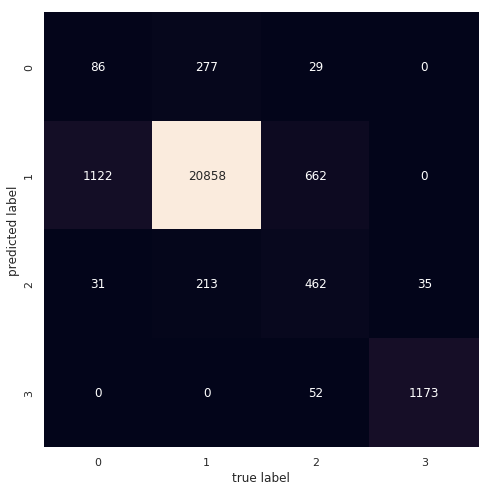

In [12]:
# Creating confusin matrix and heat map
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test, label_rf)
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cbar=False)
           #, xticklabels=train.target_names
           #, yticklabels=train.target_names)

#Plotting heatmap of Confusion Matrix
plt.xlabel('true label')
plt.ylabel('predicted label');

In [13]:
some_data = olympics.iloc[40:55]
some_labels = labels.iloc[40:55]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", forest.predict(some_data_prepared)),some_labels

Predictions:	 ['Bronze' 'Copper' 'Gold' 'Copper' 'Gold' 'Copper' 'Copper' 'Copper'
 'Gold' 'Copper' 'Copper' 'Copper' 'Copper' 'Copper' 'Copper']


(None, 40    Bronze
 41    Bronze
 42      Gold
 43    Copper
 44      Gold
 45    Copper
 46    Copper
 47    Copper
 48      Gold
 49    Copper
 50    Bronze
 51    Copper
 52    Copper
 53    Copper
 54    Copper
 Name: Medal, dtype: object)

In [15]:
from sklearn.linear_model import LogisticRegression
lin_reg = LogisticRegression(solver='lbfgs',max_iter=300,multi_class='multinomial',random_state=0)
lin_reg.fit(X_train, y_train)
label_log = lin_reg.predict(X_test)
print('Accuracy on the training subset: {:3f}'.format(lin_reg.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(lin_reg.score(X_test, y_test)))


Accuracy on the training subset: 0.901893
Accuracy on the testing subset: 0.899480


/home/saazi/ml/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


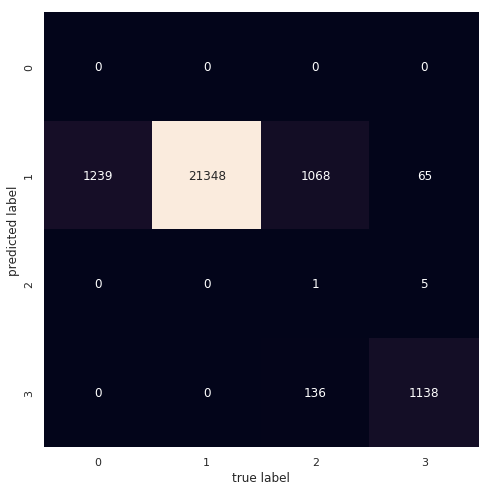

In [16]:
# Creating confusin matrix and heat map
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test, label_log)
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cbar=False)
           #, xticklabels=train.target_names
           #, yticklabels=train.target_names)

#Plotting heatmap of Confusion Matrix
plt.xlabel('true label')
plt.ylabel('predicted label');

In [17]:
#Naive bayes doesnt require scaling of the data and performs as good as logistic regression
from sklearn.naive_bayes import MultinomialNB

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
   # ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('label_binarizer', MultiColumnLabelEncoder())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

prepared = full_pipeline.fit_transform(olympics)
#prepared

#data["Category"] = encoder.fit_transform(data["Category"].astype('str'))
#features = df.drop(["Medal"], axis=1)

labels = olympics["Medal"]



X_train, X_test, y_train ,y_test = train_test_split(prepared, labels, random_state= 0)



nbm = MultinomialNB()
nbm.fit(X_train, y_train)
label = nbm.predict(X_test)

print('Accuracy on the training subset: {:3f}'.format(nbm.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(nbm.score(X_test, y_test)))


Accuracy on the training subset: 0.865280
Accuracy on the testing subset: 0.861000


In [18]:
#Naive bayes doesnt require scaling of the data and performs as good as logistic regression
from sklearn.naive_bayes import GaussianNB

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('label_binarizer', MultiColumnLabelEncoder())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

prepared = full_pipeline.fit_transform(olympics)
#prepared

#data["Category"] = encoder.fit_transform(data["Category"].astype('str'))
#features = df.drop(["Medal"], axis=1)

labels = olympics["Medal"]



X_train, X_test, y_train ,y_test = train_test_split(prepared, labels, random_state= 0)



nb = GaussianNB()
nb.fit(X_train, y_train)

print('Accuracy on the training subset: {:3f}'.format(nb.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(nb.score(X_test, y_test)))


Accuracy on the training subset: 0.891413
Accuracy on the testing subset: 0.888320


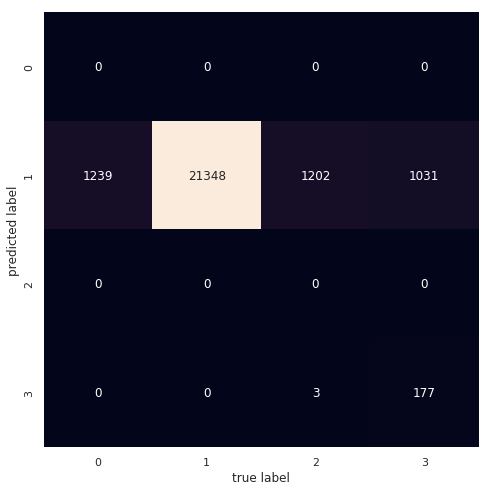

In [19]:
# Creating confusin matrix and heat map
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test, label)
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cbar=False)
           #, xticklabels=train.target_names
           #, yticklabels=train.target_names)

#Plotting heatmap of Confusion Matrix
plt.xlabel('true label')
plt.ylabel('predicted label');

In [212]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

cat_attributes = ["Sex","NOC","Games","Sport","City","Season","Event","Medal"]
features = olympics.drop(cat_attributes, axis=1)

labels = olympics["Medal"]

X_train, X_test, y_train ,y_test = train_test_split(features, labels, random_state= 0)

pipe = Pipeline([("scaler", MinMaxScaler()), ("forest", RandomForestClassifier(n_jobs=-1,
                                                        max_depth=100,n_estimators=100,
                                                       random_state=0))])

pipe.fit(X_train, y_train)
print('Accuracy on the training subset: {:3f}'.format(pipe.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(pipe.score(X_test, y_test)))


/home/saazi/ml/env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuracy on the training subset: 0.930280
Accuracy on the testing subset: 0.817600


In [4]:
cat = olympics.iloc[:,: ].select_dtypes(include=['object'])
#olympics.head()
cat

,Sex,NOC,Games,Season,City,Sport,Event,Medal
0,M,CHN,1992 Summer,Summer,Barcelona,Basketball,Basketball Men's Basketball,Copper
1,M,CHN,2012 Summer,Summer,London,Judo,Judo Men's Extra-Lightweight,Copper
2,M,DEN,1920 Summer,Summer,Antwerpen,Football,Football Men's Football,Copper
3,M,DEN,1900 Summer,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,F,NED,1988 Winter,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,Copper
5,F,NED,1988 Winter,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",Copper
6,F,NED,1992 Winter,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,Copper
7,F,NED,1992 Winter,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",Copper
8,F,NED,1994 Winter,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,Copper
9,F,NED,1994 Winter,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",Copper


In [5]:
olympics.dtypes

Sex        object
Age       float64
NOC        object
Games      object
Year        int64
Season     object
City       object
Sport      object
Event      object
Medal      object
BMI       float64
dtype: object